## Marketing Assignment 3

## 1. Likelihood for the Multi-nomial Logit (MNL) Model

In [2]:
import pandas as pd
import statsmodels.api as sm

# Load the data
df = pd.read_csv("conjoint_data.csv")

# Step 1: One-hot encode categorical variables (drop first to avoid multicollinearity)
df_encoded = pd.get_dummies(df, columns=['brand', 'ad'], drop_first=True)

# Step 2: Define the features (X) and target (y)
X = df_encoded[['price', 'brand_N', 'brand_P', 'ad_Yes']].astype(float)  # Ensure numeric
y = df_encoded['choice'].astype(int)  # Ensure binary integer outcome

# Step 3: Add intercept
X = sm.add_constant(X)

# Step 4: Fit Multinomial Logit Model
model = sm.MNLogit(y, X)
result = model.fit(method='newton', full_output=True, maxiter=100, disp=True)

# Step 5: Print results
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.565003
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                 choice   No. Observations:                 3000
Model:                        MNLogit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Wed, 28 May 2025   Pseudo R-squ.:                  0.1123
Time:                        14:06:22   Log-Likelihood:                -1695.0
converged:                       True   LL-Null:                       -1909.5
Covariance Type:            nonrobust   LLR p-value:                 1.454e-91
  choice=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8818      0.132      6.680      0.000       0.623       1.141
price         -0.0901      0.

## 2. Simulate Conjoint Data

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(123)

brands = ["N", "P", "H"]               # N = Netflix, P = Prime, H = Hulu (baseline)
ads = ["Yes", "No"]                    # Ads present or not
prices = np.arange(8, 33, 4)           # Price from $8 to $32 in $4 increments

profiles = pd.DataFrame([
    (b, a, p) for b in brands for a in ads for p in prices
], columns=["brand", "ad", "price"])

brand_util = {"N": 1.0, "P": 0.5, "H": 0.0}     # Reference: H = 0
ad_util = {"Yes": -0.8, "No": 0.0}              # Reference: Ad-free = 0
price_util = lambda p: -0.1 * p                 # Linear price penalty

n_respondents = 100
n_tasks = 10
n_alts = 3

def simulate_respondent(resp_id):
    respondent_data = []

    for task_id in range(1, n_tasks + 1):
        # Randomly sample 3 profiles (alternatives)
        alts = profiles.sample(n=n_alts).copy()

        # Compute deterministic part of utility
        v = (
            alts["brand"].map(brand_util) +
            alts["ad"].map(ad_util) +
            alts["price"].apply(price_util)
        )

        # Add Gumbel-distributed random error
        epsilon = -np.log(-np.log(np.random.rand(n_alts)))
        u = v + epsilon

        # Choose the alternative with the highest utility
        alts["choice"] = (u == u.max()).astype(int)

        # Add respondent and task identifiers
        alts["resp"] = resp_id
        alts["task"] = task_id

        # Append to list
        respondent_data.append(alts)

    return pd.concat(respondent_data)

simulated_data = pd.concat([
    simulate_respondent(i) for i in range(1, n_respondents + 1)
])

simulated_data = simulated_data[["resp", "task", "brand", "ad", "price", "choice"]]

# Preview result
print(simulated_data.head())



    resp  task brand  ad  price  choice
27     1     1     P  No     32       0
12     1     1     N  No     28       0
11     1     1     N  No     24       1
40     1     2     H  No     28       0
35     1     2     H  No      8       1



## 3. Preparing the Data for Estimation

In [4]:

df = simulated_data.copy()
df_encoded = pd.get_dummies(df, columns=["brand", "ad"], drop_first=True)

# Step 3: Confirm your columns
# You should now have: brand_N, brand_P, ad_Yes, price
print(df_encoded.head())

# Step 4: Optional – sort by respondent and task (not necessary for model, but helpful)
df_encoded = df_encoded.sort_values(by=["resp", "task"])

# Step 5: Define X (predictors) and y (choice indicator)
X_cols = ['price', 'brand_N', 'brand_P', 'ad_Yes']
X = df_encoded[X_cols]
y = df_encoded['choice']

# Step 6: Add intercept
import statsmodels.api as sm
X = sm.add_constant(X)

# Ready for estimation
print(X.head())
print(y.head())


    resp  task  price  choice  brand_N  brand_P  ad_Yes
27     1     1     32       0    False     True   False
12     1     1     28       0     True    False   False
11     1     1     24       1     True    False   False
40     1     2     28       0    False    False   False
35     1     2      8       1    False    False   False
    const  price  brand_N  brand_P  ad_Yes
27    1.0     32    False     True   False
12    1.0     28     True    False   False
11    1.0     24     True    False   False
40    1.0     28    False    False   False
35    1.0      8    False    False   False
27    0
12    0
11    1
40    0
35    1
Name: choice, dtype: int64


## 4. Estimation via Maximum Likelihood

In [7]:
from scipy.optimize import minimize
import numpy as np

# Ensure arrays are cleanly formatted
X_np = np.asarray(X.to_numpy(), dtype=np.float64)
y_np = np.asarray(y.to_numpy(), dtype=np.int64)

# Number of alternatives per task
J = 3

# Define the MNL log-likelihood function
def mnl_log_likelihood(beta):
    beta = np.asarray(beta, dtype=np.float64)
    utility = np.dot(X_np, beta).reshape(-1, J)
    y_reshaped = y_np.reshape(-1, J)

    # Apply stability trick for exponentiation
    utility_adj = utility - utility.max(axis=1, keepdims=True)
    exp_u = np.exp(utility_adj)
    probs = exp_u / exp_u.sum(axis=1, keepdims=True)

    # Pick only probabilities of chosen alternatives
    chosen_probs = probs[y_reshaped == 1]
    log_likelihood = np.sum(np.log(chosen_probs + 1e-12))  # avoid log(0)

    return -log_likelihood  # Negative for minimization

# Initial guess for beta
initial_beta = np.zeros(X_np.shape[1])

# Run optimization
result = minimize(mnl_log_likelihood, initial_beta, method='BFGS')

# Output
print("Optimization success:", result.success)
print("Estimated beta coefficients:", result.x)
print("Final log-likelihood:", -result.fun)


Optimization success: True
Estimated beta coefficients: [ 0.         -0.09641815  1.05689172  0.47329576 -0.7723847 ]
Final log-likelihood: -863.5783346348348


In [9]:
from scipy.optimize import minimize

# Prepare data
X_np = np.asarray(X.to_numpy(), dtype=np.float64)
y_np = np.asarray(y.to_numpy(), dtype=np.int64)
J = 3  # Alternatives per task

# Log-likelihood function
def mnl_log_likelihood(beta):
    beta = np.asarray(beta, dtype=np.float64)
    utility = np.dot(X_np, beta).reshape(-1, J)
    y_reshaped = y_np.reshape(-1, J)

    utility_adj = utility - utility.max(axis=1, keepdims=True)  # for stability
    exp_u = np.exp(utility_adj)
    probs = exp_u / exp_u.sum(axis=1, keepdims=True)

    chosen_probs = probs[y_reshaped == 1]
    log_likelihood = np.sum(np.log(chosen_probs + 1e-12))
    return -log_likelihood  # minimize negative log-likelihood

# Initial guess
initial_beta = np.zeros(X_np.shape[1])

# Run MLE
result = minimize(mnl_log_likelihood, initial_beta, method='BFGS')

# Extract estimates and Hessian
beta_hat = result.x
hessian_inv = result.hess_inv  # Inverse Hessian = covariance matrix

# Calculate standard errors
standard_errors = np.sqrt(np.diag(hessian_inv))

# Construct 95% confidence intervals
z = 1.96
ci_lower = beta_hat - z * standard_errors
ci_upper = beta_hat + z * standard_errors

# Display results in a DataFrame
summary = pd.DataFrame({
    'Parameter': X.columns,
    'Estimate': beta_hat,
    'Std. Error': standard_errors,
    'CI Lower (95%)': ci_lower,
    'CI Upper (95%)': ci_upper
})

print(summary)


  Parameter  Estimate  Std. Error  CI Lower (95%)  CI Upper (95%)
0     const  0.000000    1.000000       -1.960000        1.960000
1     price -0.096418    0.006056       -0.108288       -0.084549
2   brand_N  1.056892    0.096609        0.867539        1.246245
3   brand_P  0.473296    0.091216        0.294513        0.652079
4    ad_Yes -0.772385    0.094500       -0.957604       -0.587165


## 5. Estimation via Bayesian Methods

  Parameter  Posterior Mean  CI Lower (95%)  CI Upper (95%)
0     price       -0.095042       -0.107740       -0.083538
1   brand_N        1.023532        0.790482        1.267125
2   brand_P        0.467587        0.221159        0.702555
3    ad_Yes       -0.559417       -0.837536       -0.184598


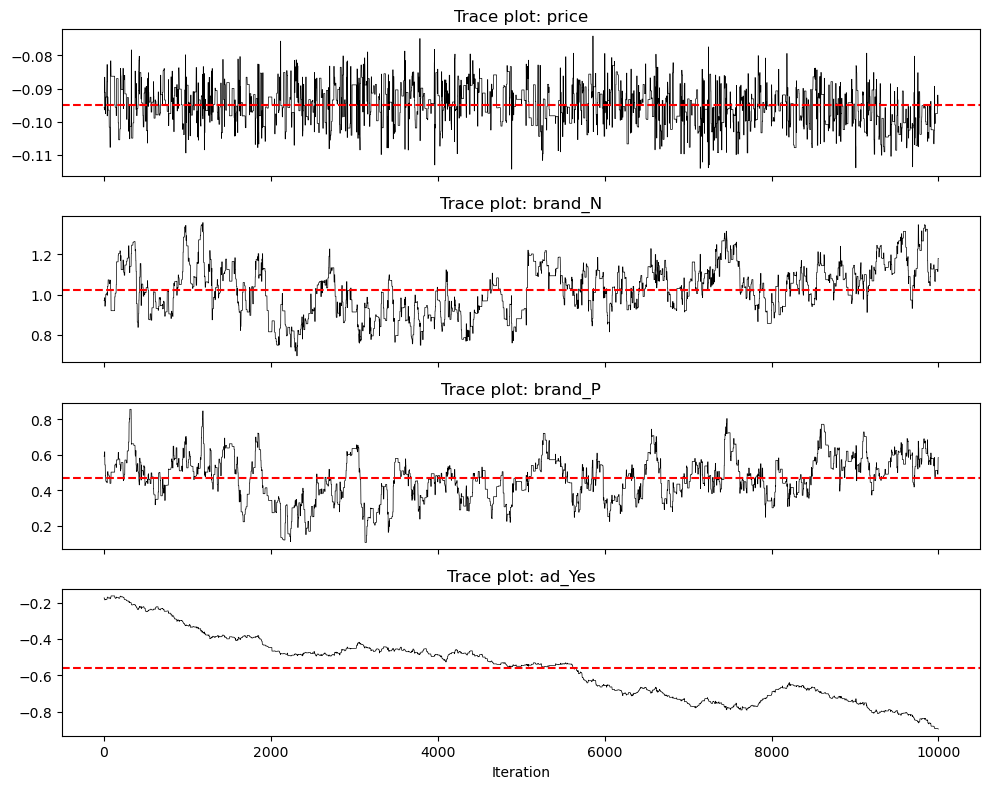

In [10]:

from scipy.special import logsumexp
import matplotlib.pyplot as plt

# Step 1: Use only actual variables (no intercept)
X_bayes = X.drop(columns=['const'])
X_np = np.asarray(X_bayes.to_numpy(), dtype=np.float64)
y_np = np.asarray(y.to_numpy(), dtype=np.int64)
J = 3  # 3 alternatives per task

# Step 2: Log-likelihood function
def mnl_log_likelihood(beta):
    beta = np.asarray(beta, dtype=np.float64)
    utility = np.dot(X_np, beta).reshape(-1, J)
    y_reshaped = y_np.reshape(-1, J)
    
    # Stability fix
    log_prob = utility - logsumexp(utility, axis=1, keepdims=True)
    chosen_log_prob = log_prob[y_reshaped == 1]
    
    return np.sum(chosen_log_prob)

# Step 3: Log-prior function
def log_prior(beta):
    # N(0, 5^2) for first 3 (binary vars), N(0, 1^2) for price
    return -0.5 * ((beta[0:3]**2 / 25).sum() + (beta[3]**2))

# Step 4: Log-posterior function
def log_posterior(beta):
    return mnl_log_likelihood(beta) + log_prior(beta)

# Step 5: Metropolis-Hastings MCMC
n_steps = 11000
burn_in = 1000
samples = []

current_beta = np.zeros(4)
current_log_post = log_posterior(current_beta)

proposal_sds = np.array([0.05, 0.05, 0.05, 0.005])

for step in range(n_steps):
    proposal = current_beta + np.random.normal(0, proposal_sds)
    proposal_log_post = log_posterior(proposal)
    
    log_accept_ratio = proposal_log_post - current_log_post
    if np.log(np.random.rand()) < log_accept_ratio:
        current_beta = proposal
        current_log_post = proposal_log_post
    
    samples.append(current_beta.copy())

# Step 6: Analyze posterior
samples_np = np.array(samples)
posterior_samples = samples_np[burn_in:]  # discard burn-in

posterior_means = posterior_samples.mean(axis=0)
lower_bounds = np.percentile(posterior_samples, 2.5, axis=0)
upper_bounds = np.percentile(posterior_samples, 97.5, axis=0)

posterior_summary = pd.DataFrame({
    'Parameter': X_bayes.columns,
    'Posterior Mean': posterior_means,
    'CI Lower (95%)': lower_bounds,
    'CI Upper (95%)': upper_bounds
})

# Step 7: Display summary
print(posterior_summary)

# Step 8: Optional – Trace plots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
param_names = X_bayes.columns

for i in range(4):
    axes[i].plot(posterior_samples[:, i], color='black', linewidth=0.5)
    axes[i].set_title(f'Trace plot: {param_names[i]}')
    axes[i].axhline(posterior_means[i], color='red', linestyle='--')

plt.xlabel("Iteration")
plt.tight_layout()
plt.show()


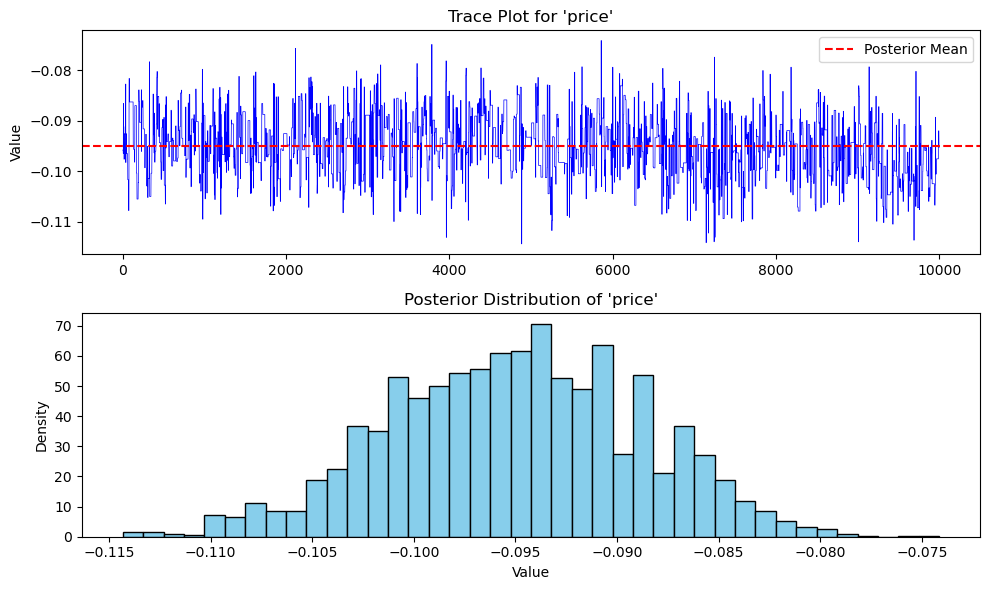

In [11]:
import matplotlib.pyplot as plt

# Step 1: Select 'price' parameter samples from posterior
param_index = list(X_bayes.columns).index('price')
param_samples = posterior_samples[:, param_index]

# Step 2: Plot trace and histogram
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Trace plot
axes[0].plot(param_samples, color='blue', linewidth=0.5)
axes[0].set_title("Trace Plot for 'price'")
axes[0].set_ylabel("Value")
axes[0].axhline(param_samples.mean(), color='red', linestyle='--', label='Posterior Mean')
axes[0].legend()

# Histogram
axes[1].hist(param_samples, bins=40, color='skyblue', edgecolor='black', density=True)
axes[1].set_title("Posterior Distribution of 'price'")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np

# --- Step 1: MLE Summary Table ---
# Calculate 95% confidence intervals using standard normal quantile
z = 1.96
ci_lower = beta_hat - z * standard_errors
ci_upper = beta_hat + z * standard_errors

summary_df = pd.DataFrame({
    'Parameter': X.columns,
    'Estimate': beta_hat,
    'Std. Error': standard_errors,
    'CI Lower (95%)': ci_lower,
    'CI Upper (95%)': ci_upper
})

# --- Step 2: Bayesian Posterior Statistics ---
posterior_std = posterior_samples.std(axis=0)

# --- Step 3: Match MLE to Bayesian parameter set (exclude intercept) ---
mle_summary = summary_df.set_index("Parameter").loc[X_bayes.columns]

# --- Step 4: Final Comparison Table ---
comparison_df = pd.DataFrame({
    "Parameter": X_bayes.columns,
    "Bayesian Mean": posterior_means,
    "Bayesian Std": posterior_std,
    "Bayesian CI Lower (95%)": lower_bounds,
    "Bayesian CI Upper (95%)": upper_bounds,
    "MLE Estimate": mle_summary["Estimate"].values,
    "MLE Std. Error": mle_summary["Std. Error"].values,
    "MLE CI Lower (95%)": mle_summary["CI Lower (95%)"].values,
    "MLE CI Upper (95%)": mle_summary["CI Upper (95%)"].values
})

# --- Step 5: Display Table ---
print(comparison_df)


  Parameter  Bayesian Mean  Bayesian Std  Bayesian CI Lower (95%)  \
0     price      -0.095042      0.006200                -0.107740   
1   brand_N       1.023532      0.124153                 0.790482   
2   brand_P       0.467587      0.123393                 0.221159   
3    ad_Yes      -0.559417      0.175565                -0.837536   

   Bayesian CI Upper (95%)  MLE Estimate  MLE Std. Error  MLE CI Lower (95%)  \
0                -0.083538     -0.096418        0.006056           -0.108288   
1                 1.267125      1.056892        0.096609            0.867539   
2                 0.702555      0.473296        0.091216            0.294513   
3                -0.184598     -0.772385        0.094500           -0.957604   

   MLE CI Upper (95%)  
0           -0.084549  
1            1.246245  
2            0.652079  
3           -0.587165  


## 6. Discussion


Even if we didn’t know this was simulated data, the model results still tell a pretty clear story. First, we can see that Netflix has the highest utility—its coefficient is larger than Amazon Prime’s. That means, all else being equal, people are more likely to choose Netflix over Prime, and both are preferred over Hulu (which was the baseline in our model). This fits with what we might expect in real life, given Netflix’s strong brand and large content library.

The fact that βₙₑₜ𝒻ₗᵢ𝓍 > βₚᵣᵢₘₑ simply means that switching from Prime to Netflix increases the chance of a consumer choosing that option—it gives more "utility" to the user in the model’s eyes.

Also, price has a negative effect, which totally makes sense. As the subscription price goes up, the probability of someone picking that service goes down. This reflects basic consumer behavior: people generally prefer cheaper options when everything else is the same.

So overall, the results look reasonable and match how we’d expect people to behave when choosing between streaming platforms.



If we wanted to make our model more realistic—like what we’d use for real-world conjoint analysis—we’d need to move to a multi-level model (also called a hierarchical or random-parameter model).

Right now, our model assumes that everyone thinks the same way—that all consumers value Netflix, ads, and price the same. But that’s not how people actually behave. Some might love Netflix, others might prefer Prime, and some may be more price-sensitive than others.

In a multi-level model, we fix that by giving each person their own set of preferences. Instead of one set of beta values, we assume each individual has their own, drawn from a larger population distribution. So for example, my β values might come from a normal distribution centered around the average consumer, but they still reflect my personal tastes.

To simulate this kind of data, we’d just draw a different set of betas for each respondent and then generate their choices based on those personal betas. And to estimate the model, we’d no longer just estimate one set of coefficients—we’d estimate the distribution those betas come from (like the mean and variance), and maybe even estimate each person’s betas too.

It’s more complex, but it’s also more powerful, because it captures the fact that people are different. That’s why hierarchical models are the go-to for analyzing real conjoint survey data.